In [ ]:
# Adrian Marinovich
# Springboard - Data Science Career Track
# Clustering Exercise
# November 2, 2018

# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import scipy as sp

from sklearn.cross_validation import train_test_split

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn.decomposition
from sklearn.decomposition import PCA

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from six.moves import range

from mpl_toolkits.mplot3d import Axes3D

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [4]:
df_offers = pd.read_excel("data/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel("data/WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [6]:
print("offers:", len(df_offers))
print("transactions:", len(df_transactions))
print("customers:", len(df_transactions.groupby('customer_name')))
print("varietals:", len(df_offers.groupby('varietal')))
print("origins:", len(df_offers.groupby('origin')))

offers: 32
transactions: 324
customers: 100
varietals: 9
origins: 9


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [7]:
#your turn

# Merge transactions and offers
to = pd.merge(df_transactions, df_offers, on='offer_id')

# Pivot offers and create matrix
tox = to.pivot_table(index=['customer_name'], columns=['offer_id'], values='n', fill_value=0)

# Make index a column
tox = tox.reset_index()

# Clean up
del to

In [8]:
print("pivot:", tox.shape)

pivot: (100, 33)


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller values of SS would represent better clusterings, since they would indicate smaller distances between a given cluster's datapoints and its centroid.

In [9]:
# your turn

# Get offer columns
toxcol = tox.iloc[:,1:33]
toxcol.shape

# Note that the original tox set (with appropriate iloc)
#  will be used below, instead of toxcol, to preserve 
#  customer name along with cluster id for further analysis

(100, 32)

In [10]:
del toxcol

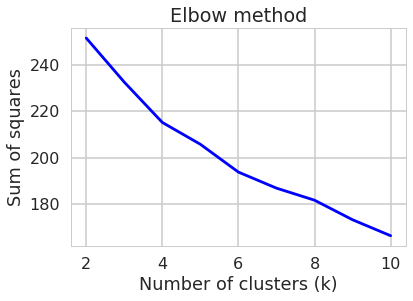

In [11]:
# k-means for various k

ssq = []
K = range(2,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=3)
    kmeanModel.fit(tox.iloc[:,1:33])
    ssq.append(sum(np.min(cdist(tox.iloc[:,1:33], kmeanModel.cluster_centers_, 'sqeuclidean'), axis=1)) )

# Plot the elbow
plt.plot(K, ssq, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squares')
plt.title('Elbow method')
plt.show()

In [12]:
# Choosing 6 as k:
cluster = KMeans(n_clusters=6, random_state=3)
tox['cluster_k6'] = cluster.fit_predict(tox.iloc[:,1:33])
print(tox.cluster_k6.value_counts())

1    28
0    23
3    16
2    15
4    14
5     4
Name: cluster_k6, dtype: int64


Text(0.5,1,'k = 6')

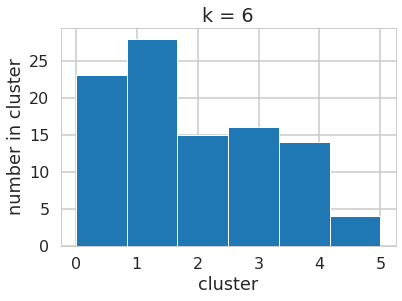

In [13]:
plt.hist(tox.cluster_k6, bins=6, edgecolor='w', lw=1)
plt.xlabel("cluster")
plt.ylabel("number in cluster")
plt.title('k = 6')

The challenge in using the elbow method in this case is there was not a very prominent 'elbow' or inflection point in the plot shown above, from which to choose an ideal k.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For 2 clusters the silhouette coefficient is : 0.09174871508750351
For 3 clusters the silhouette coefficient is : 0.10727259681647407
For 4 clusters the silhouette coefficient is : 0.1331920256860851
For 5 clusters the silhouette coefficient is : 0.13049703628907092
For 6 clusters the silhouette coefficient is : 0.13419342004299767
For 7 clusters the silhouette coefficient is : 0.13647055544933948
For 8 clusters the silhouette coefficient is : 0.11599440158252289
For 9 clusters the silhouette coefficient is : 0.12456431363698436
For 10 clusters the silhouette coefficient is : 0.12760776086434536


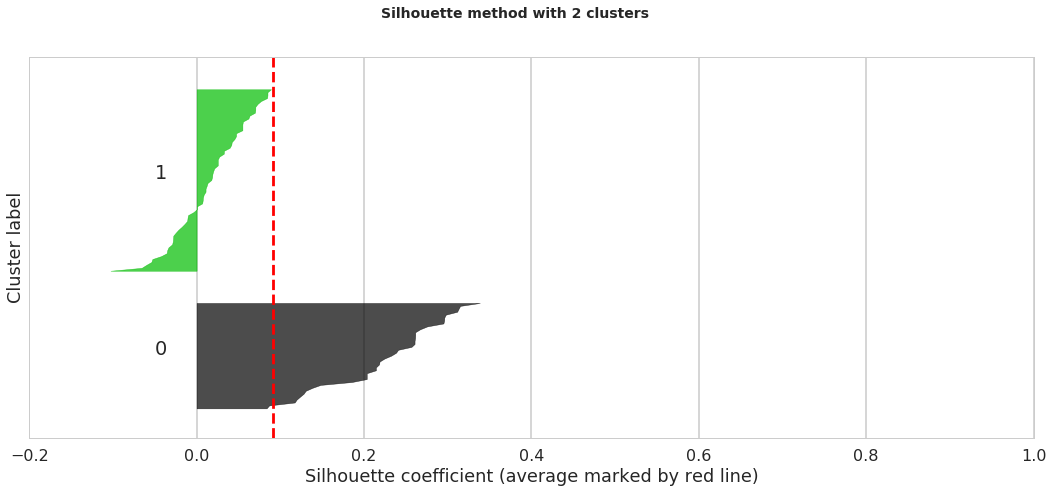

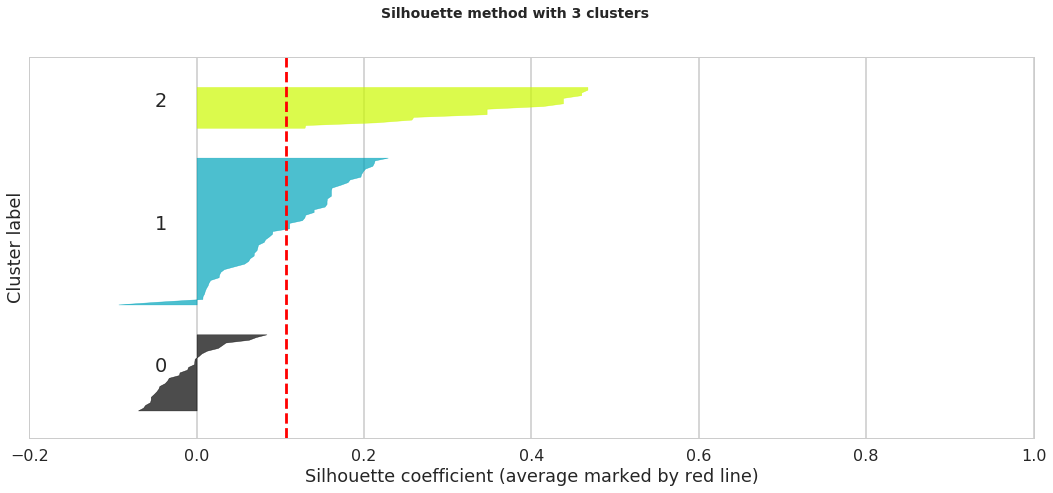

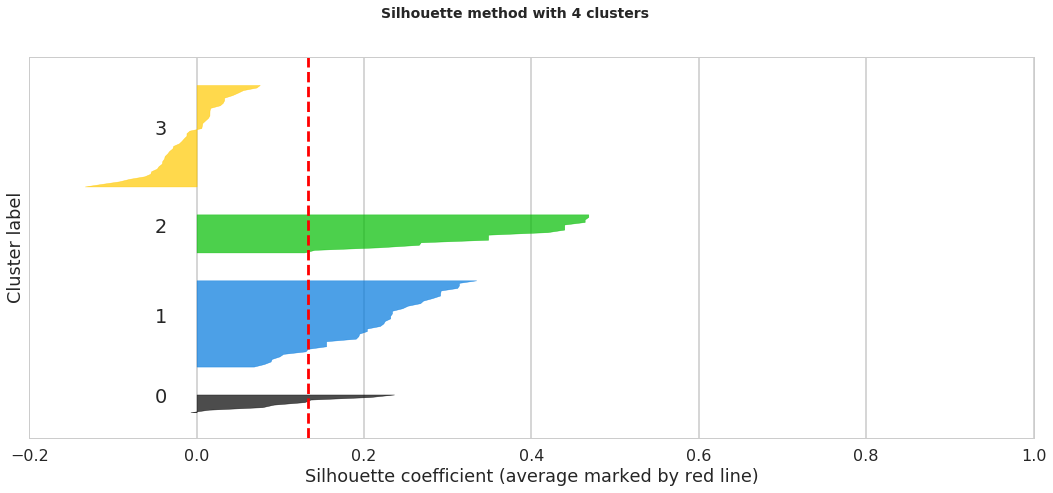

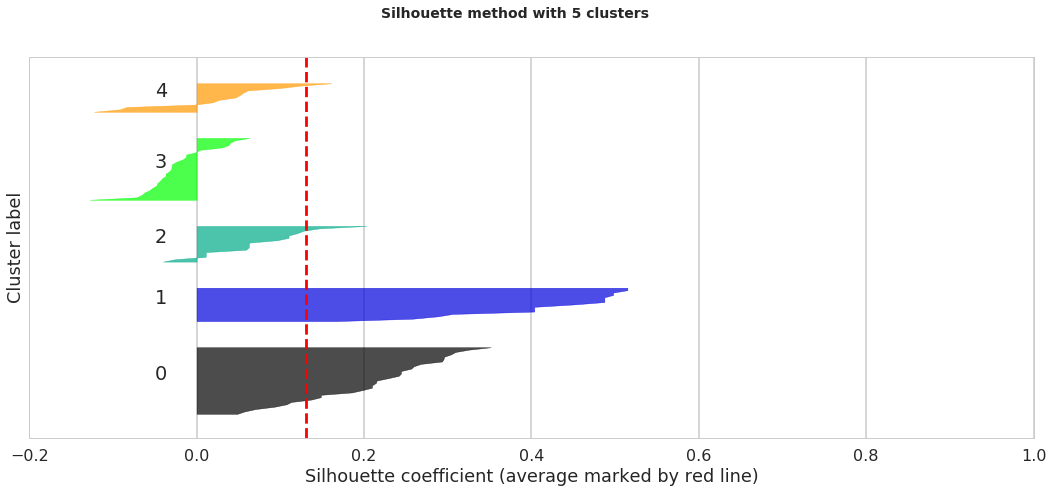

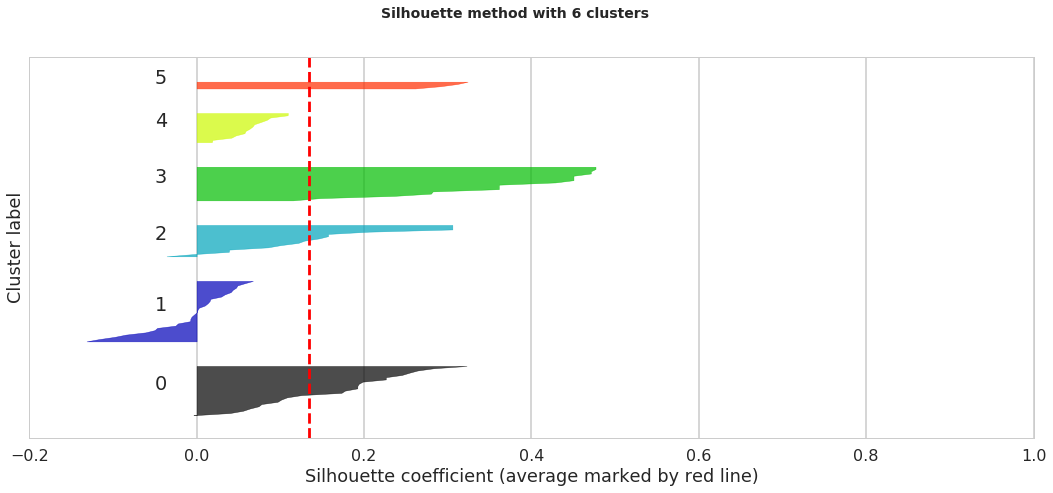

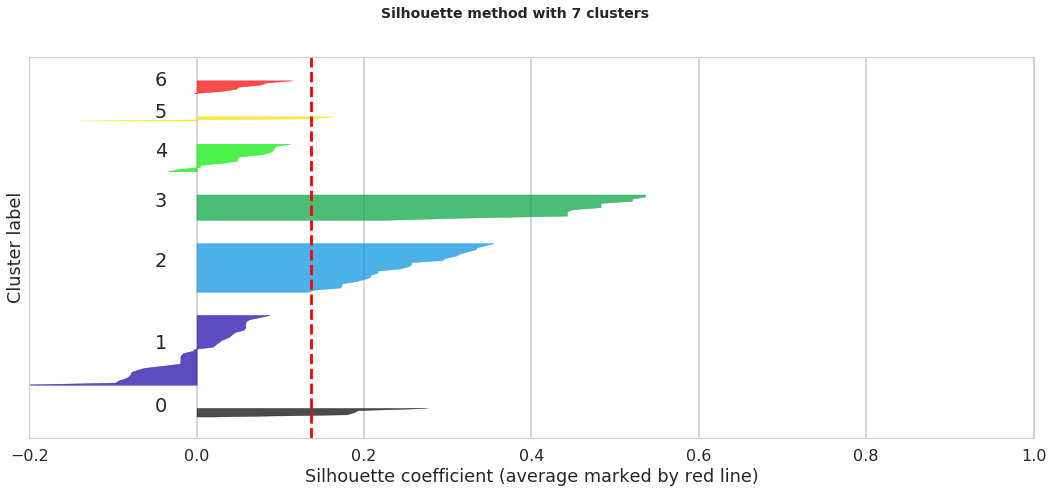

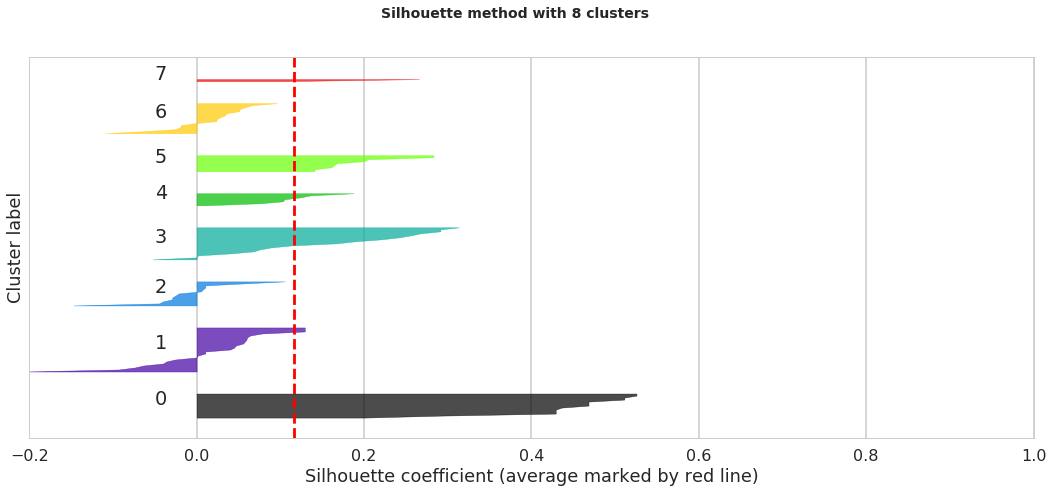

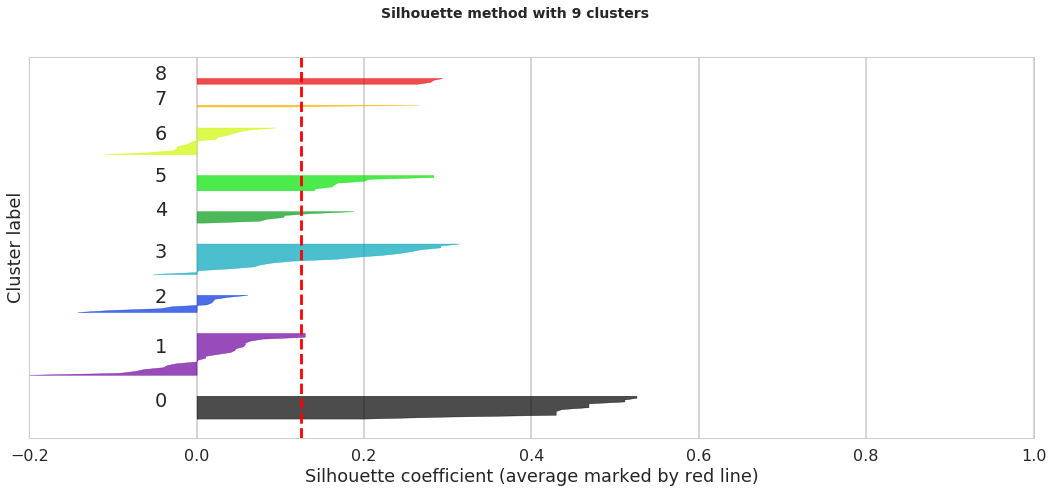

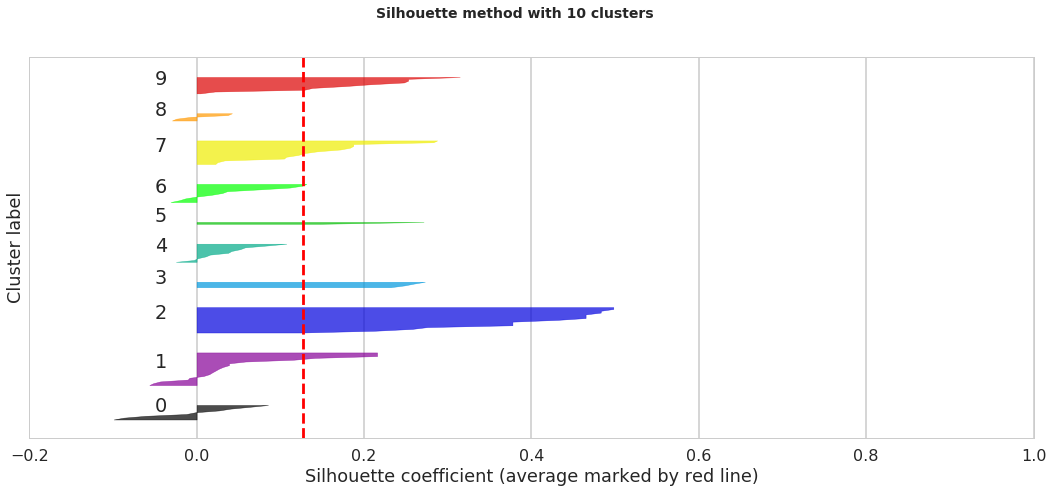

In [14]:
# Your turn.
K = range(2,11)

# (adapted from:
#   http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

for ks in K:
    # Create a subplot 
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    # insert blank space between plots with (ks+1)*10
    ax1.set_ylim([0, len(tox) + (ks + 1) * 10])

    clusterer = KMeans(n_clusters=ks, random_state=3)
    cluster_labels = clusterer.fit_predict(tox.iloc[:,1:33])

    silhouette_avg = silhouette_score(tox.iloc[:,1:33], cluster_labels)
    print("For", ks, "clusters",
          "the silhouette coefficient is :", silhouette_avg)

    # compute silhouette coeff for each sample
    sample_silhouette_values = silhouette_samples(tox.iloc[:,1:33], cluster_labels)

    y_lower = 10
    for i in range(ks):
        # aggregate silhouette coeffs and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / ks)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label silhouette plots with their cluster numbers
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_xlabel("Silhouette coefficient (average marked by red line)")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette method with %d clusters" % ks),
                 fontsize=14, fontweight='bold')

plt.show()

While the silhouette method shown above indicated k=7 as optimal, it also showed very small differences for k values from 4 through 7 (noting k=6 was chosen from the elbow method), which is consistent with the elbow method not showing a prominent elbow amongst these k values.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [15]:
tox.shape

(100, 34)

In [16]:
#your turn

pca = PCA(n_components=2)
tox['pca_x'] = pca.fit_transform(tox.iloc[:,1:33])[:,0]
tox['pca_y'] = pca.fit_transform(tox.iloc[:,1:33])[:,1]

cust_pca = tox[['customer_name', 'cluster_k6', 'pca_x', 'pca_y']]

In [17]:
cust_pca.head()

offer_id,customer_name,cluster_k6,pca_x,pca_y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,3,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,4,0.088183,-0.471695


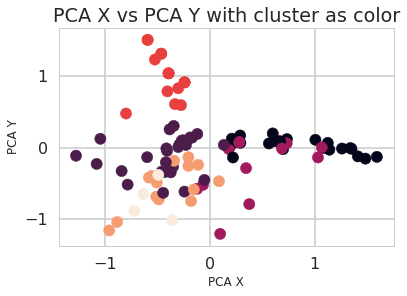

In [18]:
plt.scatter(cust_pca['pca_x'].values,cust_pca['pca_y'].values,c=cust_pca['cluster_k6'].values)
plt.xlabel('PCA X', fontsize=12)
plt.ylabel('PCA Y', fontsize=12)
plt.title('PCA X vs PCA Y with cluster as color')
plt.show()

The clusters are hard to separate completely on this 2D PCA plot. A higher dimensional PCA plot might look better. Four or more clusters seems appropriate here. While it's harder to define the appropriate upper limit of clusters here, our choice of 6 clusters by elbow method or 7 by silhouette method does not seem unreasonable.

To look at the clusters in more detail, we first must merge the customer set with cluster information back to the offers set containing information on the offers, via the transactions set:

In [19]:
tr_clstr = pd.merge(df_transactions, tox[['customer_name', 'cluster_k6']], on='customer_name')

off_tr_clstr = pd.merge(df_offers, tr_clstr, on='offer_id')

off_tr_clstr.shape

(324, 10)

In [20]:
off_tr_clstr.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_k6
0,1,January,Malbec,72,56,France,False,Thomas,1,1
1,1,January,Malbec,72,56,France,False,Jackson,1,1
2,1,January,Malbec,72,56,France,False,Mitchell,1,1
3,1,January,Malbec,72,56,France,False,Peterson,1,3
4,1,January,Malbec,72,56,France,False,Wood,1,4


Then we can look at details of each cluster based on the transaction counts of different offer characteristics, broken out by cluster:

In [112]:
clustcount = off_tr_clstr.groupby(['cluster_k6']).size().reset_index(name='count') 
print ("Number of transactions per cluster:\n", clustcount)

Number of transactions per cluster:
    cluster_k6  count
0           0     66
1           1     95
2           2     44
3           3     43
4           4     57
5           5     19


In [114]:
clustcount_v = off_tr_clstr.groupby(['cluster_k6', 'varietal']).size().reset_index(name='count') 
print ("Number of transactions per cluster x varietal:\n", clustcount_v)

Number of transactions per cluster x varietal:
     cluster_k6            varietal  count
0            0  Cabernet Sauvignon      1
1            0           Champagne      1
2            0           Espumante     17
3            0              Malbec     13
4            0              Merlot      5
5            0        Pinot Grigio     13
6            0            Prosecco     16
7            1  Cabernet Sauvignon     23
8            1           Champagne     28
9            1          Chardonnay     11
10           1           Espumante      1
11           1              Malbec     10
12           1              Merlot     10
13           1          Pinot Noir      6
14           1            Prosecco      6
15           2           Champagne     11
16           2           Espumante     20
17           2              Malbec      3
18           2              Merlot      1
19           2        Pinot Grigio      3
20           2            Prosecco      6
21           3           Cha

It's easier to see the above table in a stacked bar chart:

Text(0,0.5,'Number of transactions')

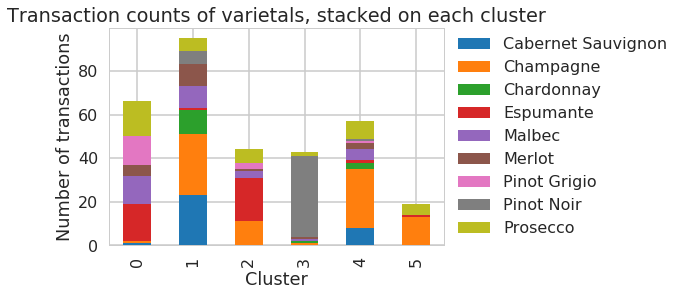

In [24]:
names_v = list(sorted(set(clustcount_v.varietal)))
clustcount2 = clustcount_v.groupby(['cluster_k6','varietal']).sum().unstack('varietal')

ax = clustcount2.plot(kind='bar', stacked='True')
ax.legend(names_v, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Transaction counts of varietals, stacked on each cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of transactions')

Some clusters have a unique dominant varietal (cluster 3 really likes Pinot Noir), but other varietals (Champagne, Espumante) tend be high sellers over 2 or more clusters.

Now we'll jump straight to the bar charts for other offer characteristics:

Text(0,0.5,'Number of transactions')

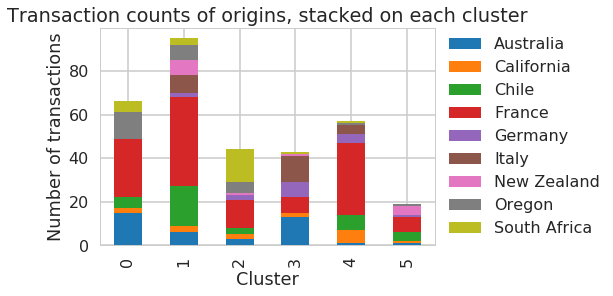

In [25]:
clustcount_o = off_tr_clstr.groupby(['cluster_k6', 'origin']).size().reset_index(name='count')

names_o = list(sorted(set(clustcount_o.origin)))
clustcount3 = clustcount_o.groupby(['cluster_k6','origin']).sum().unstack('origin')

ax = clustcount3.plot(kind='bar', stacked='True')
ax.legend(names_o, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Transaction counts of origins, stacked on each cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of transactions')

French wines are generally quite popular across clusters. Clusters 0 and 1 have a taste for Oregon wines, cluster 2 for South African wines, and clusters 1 and 5 for New Zealand wines. Cluster 3 doesn't seem to mind where it's Pinot Noir comes from.

In [26]:
clustcount_m = off_tr_clstr['min_qty'].groupby(off_tr_clstr['cluster_k6']).mean().reset_index(name='mean_min_qty')
clustcount_m

,cluster_k6,mean_min_qty
0,0,10.272727
1,1,87.031579
2,2,35.590909
3,3,65.581395
4,4,71.052632
5,5,81.157895


Text(0,0.5,'Mean minimum quantity')

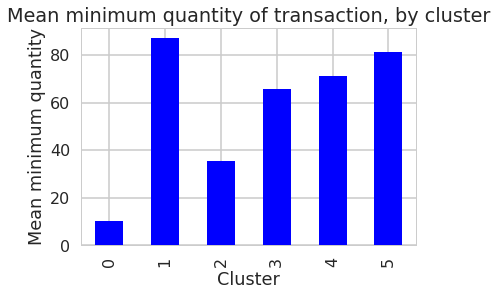

In [27]:
ax = clustcount_m['mean_min_qty'].plot(kind='bar', color='blue')
ax.set_title('Mean minimum quantity of transaction, by cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean minimum quantity')

It might be worth targeting clusters 1 and 5 with bulk order offers, cluster 3 with bulk order Pinot Noir offers, whereas clusters 0 and 2 might respond more to smaller quantity offers.

In [26]:
clustcount_d = off_tr_clstr['discount'].groupby(off_tr_clstr['cluster_k6']).mean().reset_index(name='mean_discount')
clustcount_d

,cluster_k6,mean_discount
0,0,55.393939
1,1,61.210526
2,2,55.704545
3,3,52.116279
4,4,66.982456
5,5,67.947368


In [27]:
clustcount_pp = off_tr_clstr['past_peak'].groupby(off_tr_clstr['cluster_k6']).mean().reset_index(name='past_peak_prop')
clustcount_pp

,cluster_k6,past_peak_prop
0,0,0.242424
1,1,0.231579
2,2,0.159091
3,3,0.000000
4,4,0.105263
5,5,0.315789


Text(0,0.5,'Past-peak proportion')

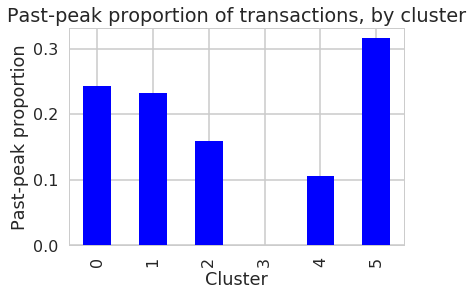

In [28]:
ax = clustcount_pp['past_peak_prop'].plot(kind='bar', color='blue')
ax.set_title('Past-peak proportion of transactions, by cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Past-peak proportion')

It seems cluster 3 really likes its Pinot Noir to NOT be past peak. Past-peak wines might better be offered to cluster 5. As shown in the table further above, all clusters had similar mean discount rates.

In [28]:
# Use function to convert 'campaign' month names to month number
def mon_nam2num(string):
    m = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April':4,
        'May':5,
        'June':6,
        'July':7,
        'August':8,
        'September':9,
        'October':10,
        'November':11,
        'December':12
        }
    out = m[string]
    return out

In [29]:
otc12 = off_tr_clstr
otc12['mon_num'] = otc12['campaign'].map(lambda a: mon_nam2num(a))
clustcount_c = otc12.groupby(['cluster_k6', 'mon_num']).size().reset_index(name='count')

Text(0,0.5,'Number of transactions')

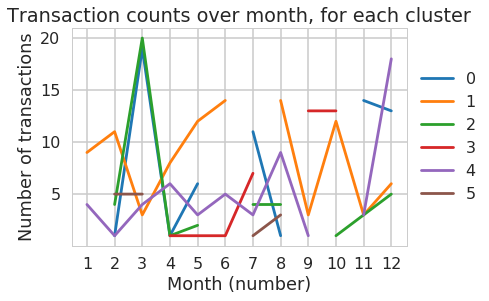

In [30]:
clustcount4 = clustcount_c.pivot(index='mon_num', columns='cluster_k6', values='count')

ax = clustcount4.plot()
ax.set_xticks(clustcount4.index)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Transaction counts over month, for each cluster')
ax.set_xlabel('Month (number)')
ax.set_ylabel('Number of transactions')

It looks like offers might be focused to cluster 0 in March and November-December, cluster 2 in March, cluster 3 in September-October, and cluster 4 in December. Clusters 1 and 5 don't have as convincing a seasonal variation. 

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [31]:
#your turn
# Initialize a new PCA model with a default number of components.

pca = sklearn.decomposition.PCA()
pca.fit(tox.iloc[:,1:33])
print(pca.explained_variance_)

[0.4096489  0.30753551 0.2022926  0.16703717 0.15015248 0.1434373
 0.13818887 0.12192294 0.11636172 0.10804271 0.09937813 0.09495961
 0.08690352 0.07256738 0.0660996  0.06245473 0.05634388 0.05327395
 0.04728801 0.04393911 0.03900424 0.03625783 0.03455714 0.03235091
 0.02940632 0.02618221 0.02308167 0.02142632 0.018814   0.0165252
 0.01426187 0.0077789 ]


In [32]:
list_v = np.array(list(enumerate(pca.explained_variance_)))

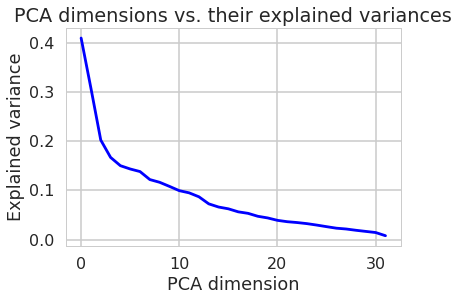

In [33]:
plt.plot(list_v[:,0], list_v[:,1], 'bx-')
plt.xlabel('PCA dimension')
plt.ylabel('Explained variance')
plt.title('PCA dimensions vs. their explained variances')
plt.show()

The most notable inflection, and therefore likely optimal dimension, is centered at the 4th PCA dimension.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn

In [48]:
# Affinity propagation
cls_ap = AffinityPropagation().fit(tox.iloc[:,1:33])
tox['cls_ap'] = cls_ap.labels_
print(set(cls_ap.labels_))
print(tox.cls_ap.value_counts())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
12    12
7     11
3     11
6     10
0      9
13     8
10     8
4      7
2      6
11     5
8      4
9      3
5      3
1      3
Name: cls_ap, dtype: int64


In [49]:
# Spectral clustering
cls_sc = SpectralClustering(n_clusters=6, assign_labels="discretize", random_state=33).fit(tox.iloc[:,1:33])
tox['cls_sc'] = cls_sc.labels_
print(set(cls_sc.labels_))
print(tox.cls_sc.value_counts())

{0, 1, 2, 3, 4, 5}
1    43
3    16
4    12
2    11
5     9
0     9
Name: cls_sc, dtype: int64


In [50]:
# Agglomerative clustering
cls_ac = AgglomerativeClustering(n_clusters=6).fit(tox.iloc[:,1:33])
tox['cls_ac'] = cls_ac.labels_
print(set(cls_ac.labels_))
print(tox.cls_ac.value_counts())

{0, 1, 2, 3, 4, 5}
1    34
0    30
2    17
3     8
4     7
5     4
Name: cls_ac, dtype: int64


In [70]:
# DBSCAN
#  This will be run on the PCA x and y values
ss = StandardScaler()
pca_t = ss.fit_transform(tox[['pca_x', 'pca_y']])
                
db = DBSCAN(eps=0.5, min_samples=3, algorithm='kd_tree')
cls_db = db.fit_predict(pca_t)
tox['cls_db'] = cls_db
print(set(cls_db))
print(tox.cls_db.value_counts())
# Note: For the DBSCAN output labels, -1 is noise

{0, 1, -1}
 0    80
 1    15
-1     5
Name: cls_db, dtype: int64


In [ ]:
# Add 3rd PCA dimension and then plot all methods on 
#  2 and 3 PCA dimensions to compare them

pca3 = PCA(n_components=3)
tox['pca_x'] = pca3.fit_transform(tox.iloc[:,1:33])[:,0]
tox['pca_y'] = pca3.fit_transform(tox.iloc[:,1:33])[:,1]
tox['pca_z'] = pca3.fit_transform(tox.iloc[:,1:33])[:,2]

Text(0.5,0.92,'DBSCAN')

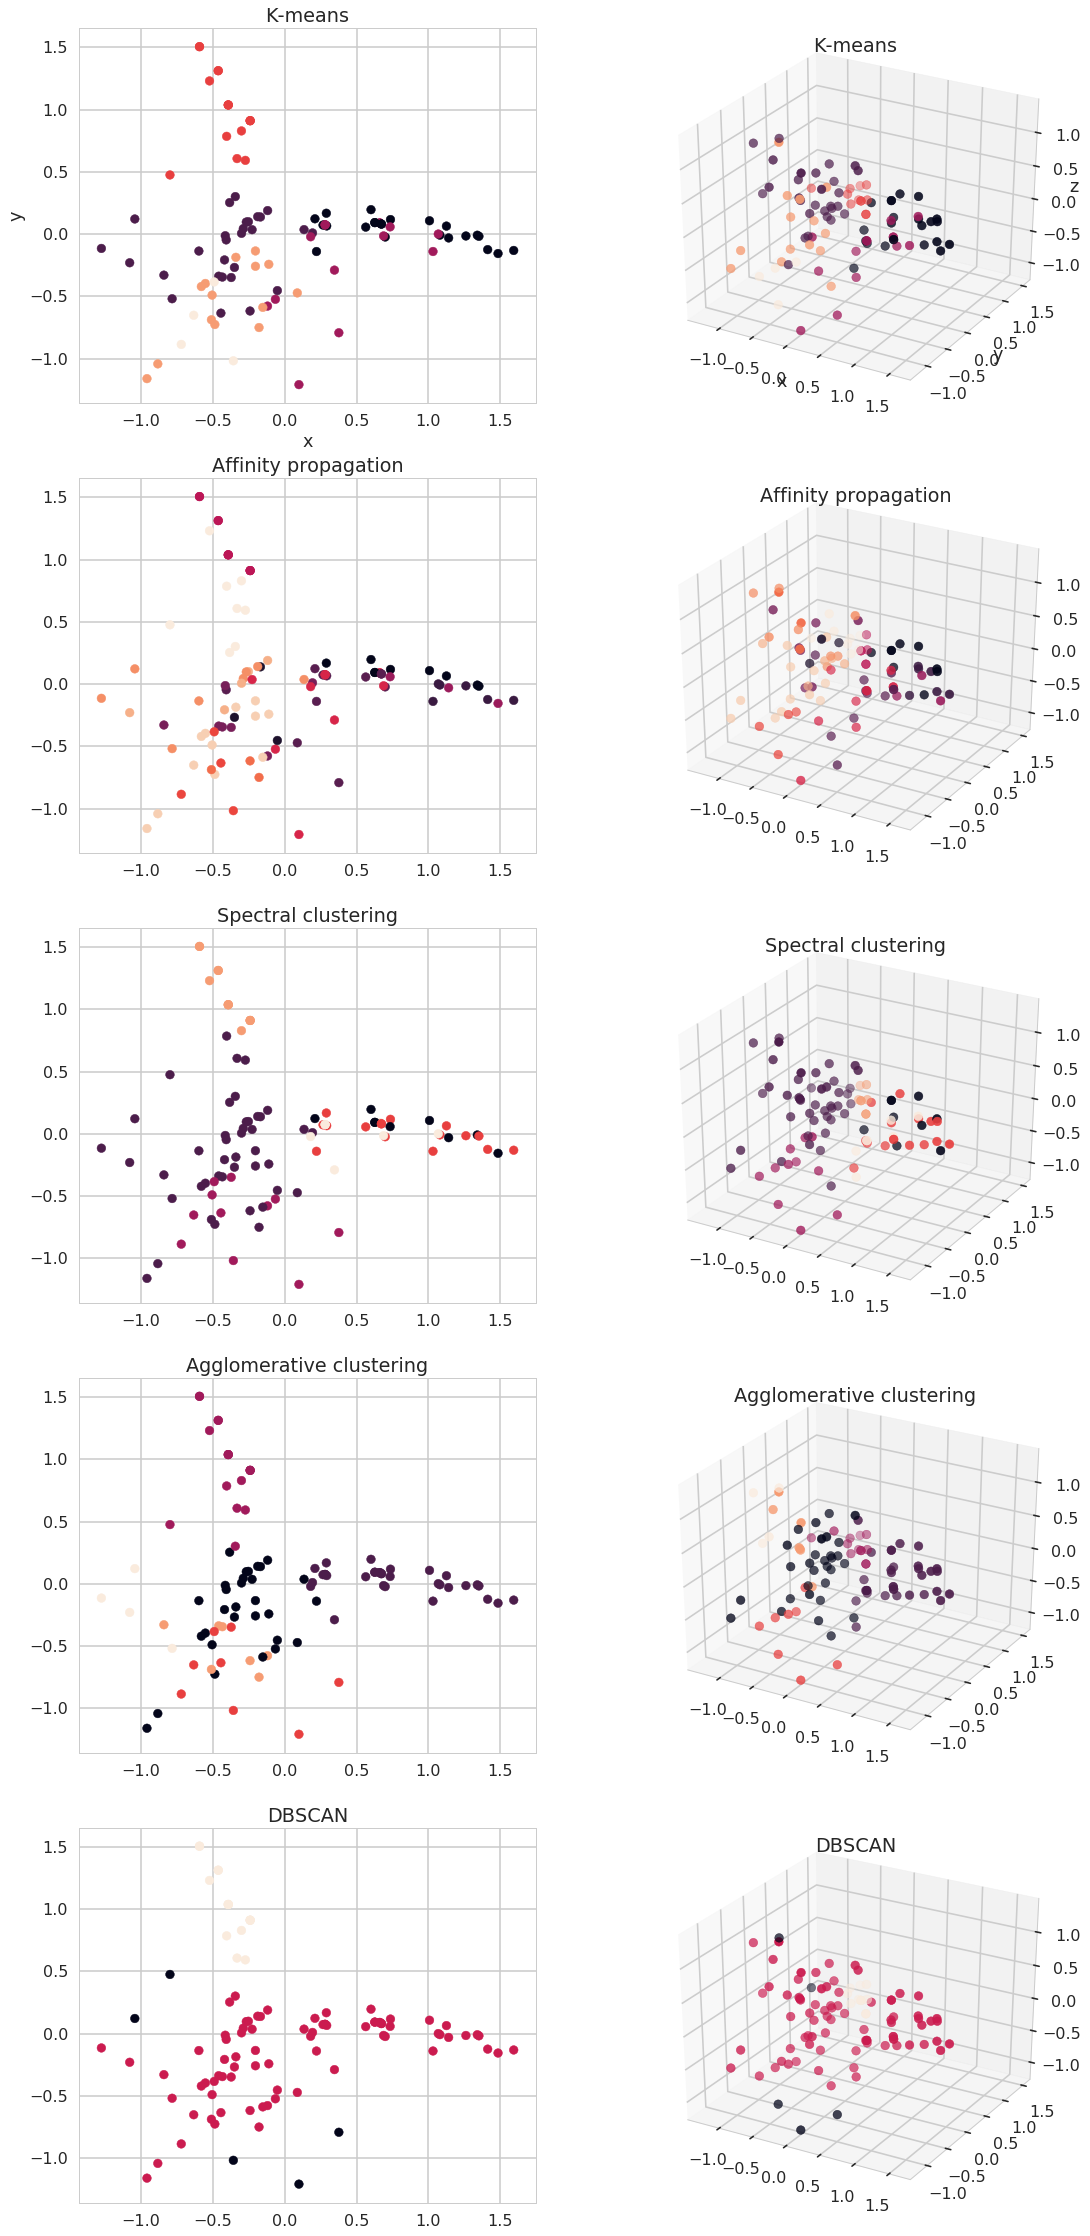

In [111]:
fig = plt.figure(figsize=(18,40))

ax1 = fig.add_subplot(521)
ax1.scatter(tox['pca_x'], tox['pca_y'], s=75, c=tox['cluster_k6'])
ax1.set_title('K-means')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax1_3 = fig.add_subplot(522, projection='3d')
ax1_3.scatter(tox['pca_x'], tox['pca_y'], tox['pca_z'], s=75, c=tox['cluster_k6'])
ax1_3.set_title('K-means')
ax1_3.set_xlabel('x')
ax1_3.set_ylabel('y')
ax1_3.set_zlabel('z')

ax2 = fig.add_subplot(523)
ax2.scatter(tox['pca_x'], tox['pca_y'], s=75, c=tox['cls_ap'])
ax2.set_title('Affinity propagation')

ax2_3 = fig.add_subplot(524, projection='3d')
ax2_3.scatter(tox['pca_x'], tox['pca_y'], tox['pca_z'], s=75, c=tox['cls_ap'])
ax2_3.set_title('Affinity propagation')

ax3 = fig.add_subplot(525)
ax3.scatter(tox['pca_x'], tox['pca_y'], s=75, c=tox['cls_sc'])
ax3.set_title('Spectral clustering')

ax3_3 = fig.add_subplot(526, projection='3d')
ax3_3.scatter(tox['pca_x'], tox['pca_y'], tox['pca_z'], s=75, c=tox['cls_sc'])
ax3_3.set_title('Spectral clustering')

ax4 = fig.add_subplot(527)
ax4.scatter(tox['pca_x'], tox['pca_y'], s=75, c=tox['cls_ac'])
ax4.set_title('Agglomerative clustering')

ax4_3 = fig.add_subplot(528, projection='3d')
ax4_3.scatter(tox['pca_x'], tox['pca_y'], tox['pca_z'], s=75, c=tox['cls_ac'])
ax4_3.set_title('Agglomerative clustering')

ax5 = fig.add_subplot(529)
ax5.scatter(tox['pca_x'], tox['pca_y'], s=75, c=tox['cls_db'])
ax5.set_title('DBSCAN')

ax5_3 = fig.add_subplot(5,2,10, projection='3d')
ax5_3.scatter(tox['pca_x'], tox['pca_y'], tox['pca_z'], s=75, c=tox['cls_db'])
ax5_3.set_title('DBSCAN')

Based on examination of these plots, the original K-means, as well as the spectral clustering and agglomerative clustering methods appear to give the best identifiable separation of clusters. Affinity propagation and DBSCAN performed poorly. It's worth noting that affinity propagation resulted in 13 clusters, a large number of clusters which may explain its poor performance. DBSCAN meanwhile resulted in only 2 clusters (in addition to a noise 'cluster'), a small number of clusters which may explain its poor performance. Interestingly, it is these two poor performers that are unique in not requiring the number of clusters to be specified by the user. The groundwork laid in identifying a likely optimal number of clusters during the K-means and PCA procedures appears to have paid off. Agglomerative clustering gave a more balanced number of members in the top 3 clusters, as compared to the spectral clustering, so agglomerative clustering may be the best alternative to K-means.